# Wikipedia Semantic Search Project

*Author: William Buck*

### Summary of download.py, search.py, and predict.py files
The three .py files that are run in this notebook will do the following, demonstrated in three parts:

**PART 1:** 
- Download all of the page text, pageids, and titles from pages from a certain category.
    - This information is stored in MongoDB which is set up on a dedicated AWS instance. The client connection is set in all three of the scripts as ```MongoClient('35.163.182.105', 27016)```
    - The way I have organized the data in MongoDB: 
        - Each category that is downloaded has its own collection in the Mongo database. 
        - A collection is also made for every subcategory of the orginally downloaded category if nesting_level is specified when you run the download.py; there will be an input field.
        - Each document in a collection is a page that falls under the category in Wikipedia.

**PART 2:** 
- Search for any word or phrase in the contents of the downloaded Wikipedia pages.
    - A DataFrame must be created in the Data/ folder of the downloaded information to search it.

**PART 3:** 
- Predict the category of a page from the Wikipdia page title.
    - predict.py analyzes all of the page content related to a certain category, and when a page title is searched, it uses the Wikipedia API to get all of the page text of the passed title, then predicts the category of the page based on that content.
    - The downloaded data must be stored in a pandas DataFrame in order for categorical predictions to be made.

**Note about search/prediction accuracy and TruncatedSVD:**
<br>TruncatedSVD is included as an option before finding cosine similarity in both the predict.py and search.py scripts. It makes the results much slower, and it also is not always completely accurate becuase I'm not using an ```ngram_range``` in the TFIDF transformation. I believe that doing this would increase the accuracy, but the the process keeps causing the kernel of my notebook to crash because its too intensive for my machine. An option if you would like to update the accuracy and/or search a larger number of Wikipedia articles would be to run these processes on an AWS EC2 instance.

# PART 1: Example of download.py 

### Getting all of the page contents for the categories specified once the download.py file is run.

A nesting level must be set due to Wikipedia's infinite nesting structure. It is impossible to get all of the subcategories using a recursive function because often, there is a child category that includes its parent category as a subcategory, which creates a loop.

**Overwrite will delete the database in mongo if it has been previously created.**

After downloading, it will ask if you would like to merge and pickle all of the collections in the Mongo database. This needs to be done if you want to search or predict on the downloaded categories later on.

---

In [2]:
import re
import requests
import pandas as pd
import numpy as np
import pymongo

from string import punctuation
from bs4 import BeautifulSoup

import sys

In [3]:
client = pymongo.MongoClient('35.163.182.105', 27016)

---
Showing the architecture of the database in more detail here. The business_software_wiki_db and machine_learning_wiki_db in MongoDB include collections, each of which contains the pages of subcategories from the originally downloaded category. They have there own databases, but you are capable of including multiple category downloads in one database, as you will see below for the 'animals' db where multiple categories were downloaded.

In [5]:
# All of the MongoDB databases.
client.database_names()

['admin',
 'all_downloads',
 'animals',
 'bicycles_wiki_db',
 'business_software_wiki_db',
 'evolutionary_phenomena_wiki_db',
 'local',
 'machine_learning_wiki_db',
 'wilderness_wiki_db']

In [9]:
# All collections are subcategories of the wiki category Machine Learning.
client.machine_learning_wiki_db.collection_names()

['Semisupervised_learning_wiki_content_collection',
 'Computational_learning_theory_wiki_content_collection',
 'Cluster_analysis_wiki_content_collection',
 'Dimension_reduction_wiki_content_collection',
 'Genetic_programming_wiki_content_collection',
 'Machine_learning_portal_wiki_content_collection',
 'Genetic_algorithms_wiki_content_collection',
 'Learning_in_computer_vision_wiki_content_collection',
 'Causal_inference_wiki_content_collection',
 'Log-linear_models_wiki_content_collection',
 'Neural_network_software_wiki_content_collection',
 'Artificial_intelligence_conferences_wiki_content_collection',
 'Clustering_criteria_wiki_content_collection',
 'Inductive_logic_programming_wiki_content_collection',
 'Artificial_immune_systems_wiki_content_collection',
 'Classification_algorithms_wiki_content_collection',
 'Nature-inspired_metaheuristics_wiki_content_collection',
 'Statistical_natural_language_processing_wiki_content_collection',
 'Markov_networks_wiki_content_collection',
 'Ba

In [11]:
# All collections are subcategories of the wiki category 'Business Software'.
client.business_software_wiki_db.collection_names()

['Office_suites_for_Linux_wiki_content_collection',
 'Zoo_Tycoon_wiki_content_collection',
 'Defunct_internet_search_engines_wiki_content_collection',
 'ASP_Accounting_Systems_wiki_content_collection',
 'Business_software_for_Windows_wiki_content_collection',
 'Free_accounting_software_wiki_content_collection',
 'Tax_software_wiki_content_collection',
 'Code_search_engines_wiki_content_collection',
 'Blog_software_wiki_content_collection',
 'GitHub_wiki_content_collection',
 'Free_TeX_software_wiki_content_collection',
 'Instant_messaging_clients_wiki_content_collection',
 'Free_search_engine_software_wiki_content_collection',
 'Email_devices_wiki_content_collection',
 'JavaServer_Faces_wiki_content_collection',
 'Online_brokerages_wiki_content_collection',
 'Git_(software)_wiki_content_collection',
 'Enterprise_resource_planning_terminology_wiki_content_collection',
 'business_software_wiki_content_collection',
 'Computer-aided_audit_tools_wiki_content_collection',
 'Free_task_managem

In [12]:
# Showing an example of the 'Business Software' category download that was stored in Mongo.
busi_soft_df = pd.DataFrame(list(client.business_software_wiki_db.business_software_wiki_content_collection.find()))
busi_soft_df[:10]

,_id,category,content,page_id,title
0,5a1486eb830fdb0909c6503b,business software,Business software or a business application is...,1037763,Business software
1,5a1486ec830fdb0909c6503c,business software,AccuSystems LLC is an American company headqua...,41270069,AccuSystems
2,5a1486ec830fdb0909c6503d,business software,Active policy management is businessoriented e...,5211212,Active policy management
3,5a1486ed830fdb0909c6503e,business software,Alexandria is browser based crossplatform libr...,28502793,Alexandria (library software)
4,5a1486ed830fdb0909c6503f,business software,Alteryx is an American computer software compa...,44133735,Alteryx
5,5a1486ed830fdb0909c65040,business software,Amadeus is a computer reservation system or gl...,12715119,Amadeus CRS
6,5a1486ee830fdb0909c65041,business software,AMS Device Manager is plant asset management s...,24061342,AMS Device Manager
7,5a1486ee830fdb0909c65042,business software,Angelfish Software is an onpremises selfhosted...,54594603,Angelfish software
8,5a1486ef830fdb0909c65043,business software,An applicant tracking system ATS is a software...,1762176,Applicant tracking system
9,5a1486ef830fdb0909c65044,business software,Application retirement also called application...,22847264,Application retirement


In [13]:
# Example of 'Machine Learning' category.
machine_learning_df = pd.DataFrame(list(client.machine_learning_wiki_db.machine_learning_wiki_content_collection.find()))
machine_learning_df[:10]

,_id,category,content,page_id,title
0,5a149a24830fdb098f50cbbd,machine learning,Data exploration is an approach similar to ini...,43385931,Data exploration
1,5a149a24830fdb098f50cbbe,machine learning,These datasets are used for machinelearning re...,49082762,List of datasets for machine learning research
2,5a149a24830fdb098f50cbbf,machine learning,Machine learning is a field of computer scienc...,233488,Machine learning
3,5a149a25830fdb098f50cbc0,machine learning,The following outline is provided as an overvi...,53587467,Outline of machine learning
4,5a149a25830fdb098f50cbc1,machine learning,The accuracy paradox for predictive analytics ...,3771060,Accuracy paradox
5,5a149a26830fdb098f50cbc2,machine learning,Action model learning sometimes abbreviated ac...,43808044,Action model learning
6,5a149a26830fdb098f50cbc3,machine learning,Active learning is a special case of semisuper...,28801798,Active learning (machine learning)
7,5a149a26830fdb098f50cbc4,machine learning,Adversarial machine learning is a research fie...,45049676,Adversarial machine learning
8,5a149a27830fdb098f50cbc5,machine learning,AIVA Artificial Intelligence Virtual Artist is...,52642349,AIVA
9,5a149a27830fdb098f50cbc6,machine learning,AIXI ai̯k͡siː is a theoretical mathematical fo...,30511763,AIXI


In [17]:
# Example content that was cleaned using beautiful soup.
machine_learning_df['content'][0]

'Data exploration is an approach similar to initial data analysis whereby a data analyst uses visual exploration to understand what is in a dataset and the characteristics of the data rather than through traditional data management systems These characteristics can include size or amount of data completeness of the data correctness of the data possible relationships amongst data elements or filestables in the data Data exploration is typically conducted using a combination of automated and manual activities Automated activities can include data profiling or data visualization or tabular reports to give the analyst an initial view into the data and an understanding of key characteristics This is often followed by manual drilldown or filtering of the data to identify anomalies or patterns identified through the automated actions Data exploration can also require manual scripting and queries into the data eg using languages such as SQL or R or using Excel or similar tools to view the raw 

## Showing examples of the download.py file with other categories.

Once you run the file, you will be asked a series of questions:

1. Name the database in Mongo
    - It is possible choose a database that already exists and overwrite it, or continue to add more categories to it if you want more articles included in the same database.
1. Name of a legitimate Wikipedia category that you would like to download all the pages for.
1. The nesting level, which is how many subcategories deep you would like to download.
    - Most categories on wikipedia have pages directly associated with them, as well as other pages that show the nested subcategories. See this diagram:

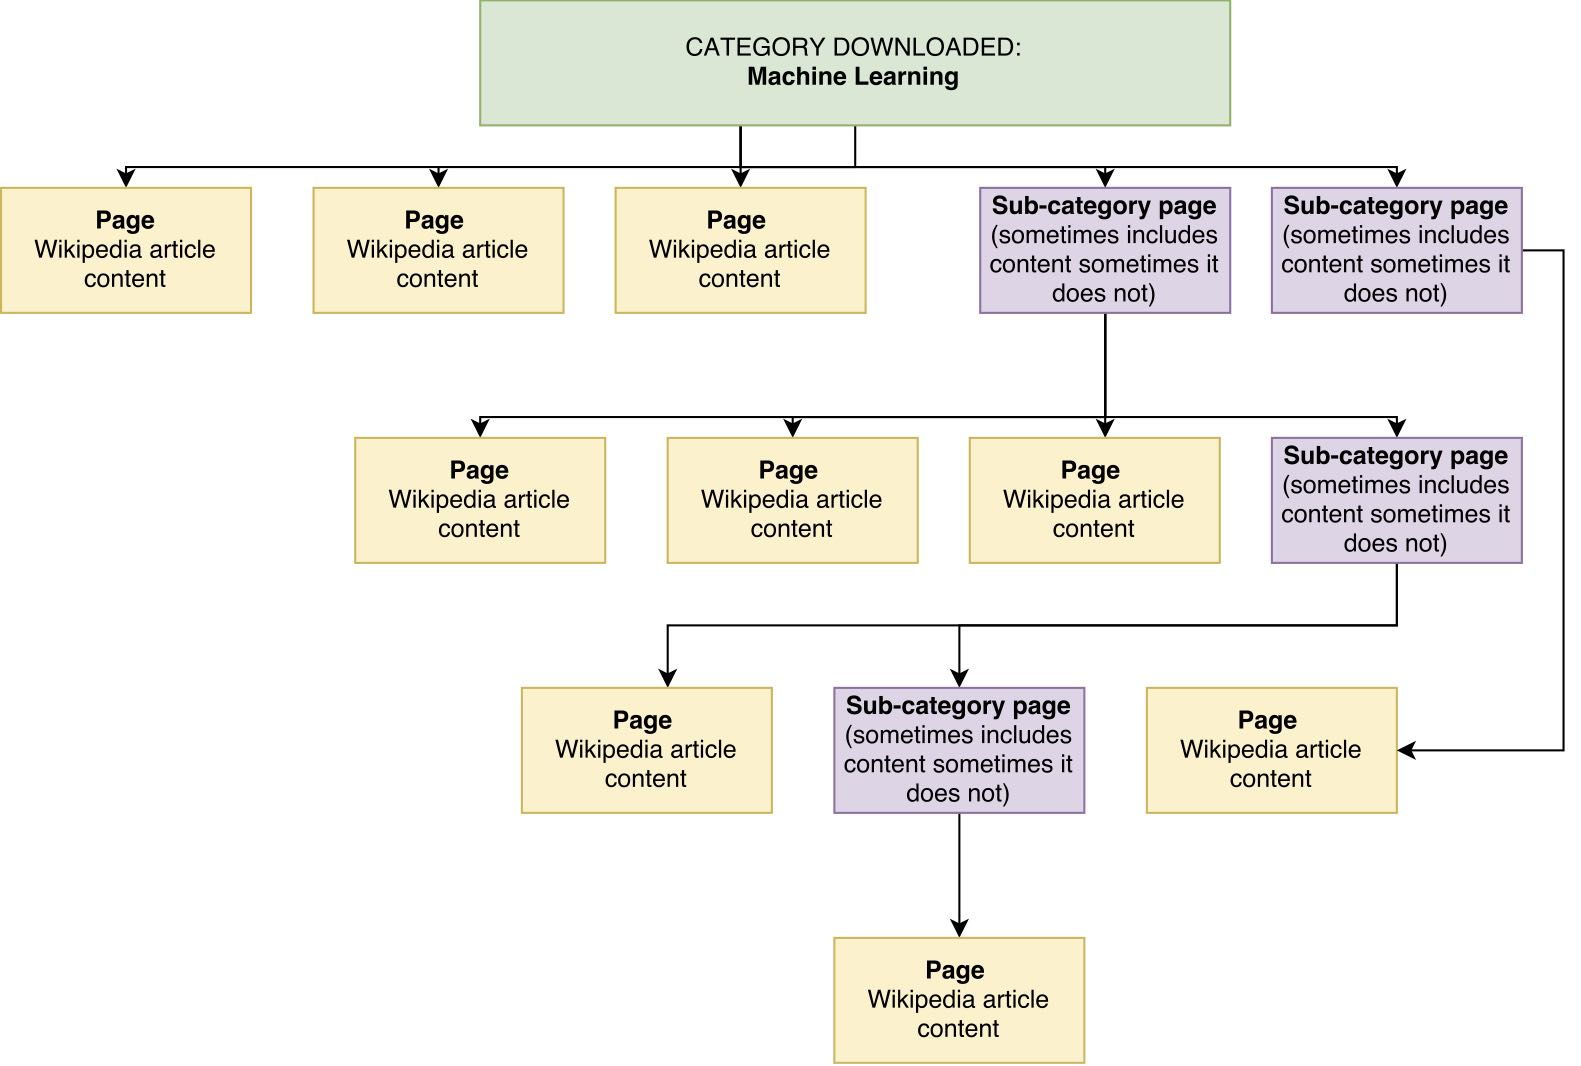
    

In [1]:
# An example of the output from the download file
%run download.py

Database name: animals
Category to download: Weasels
Nesting level: 0
Overwrite? [y/n] n

Starting download of category "Weasels"
Finished updating "animals" with all page content from category "Weasels".

There were no subcategory pages included for "Weasels".

Continue downloading? [y/n] y
Category to download: bears
Nesting level: 1

Starting download of category "bears"
Finished updating "animals" with all page content from category "bears".

There are 29 subcategories that need to be added to animals.

28.27.26.25.24.23.22.21.20.19.18.17.16.15.14.13.12.11.10.9.8.7.6.5.4.3.2.1.0.
Continue downloading? [y/n] y
Category to download: dolphins
Nesting level: 0

Starting download of category "dolphins"
Finished updating "animals" with all page content from category "dolphins".

There were no subcategory pages included for "dolphins".

Continue downloading? [y/n] n
Merge all downloads to DataFrame and pickle? [y/n] y
Completed merge.


In [13]:
# Showing the pickled DataFrame that is created after download.
animals_df = pd.read_pickle('Data/animals_download_merged_df.p')
animals_df.sample(10)

,_id,category,content,page_id,title
577,5a24ad2a830fdb056f227284,Polar bears,The Agreement on the Conservation of Polar Bea...,26621962,Agreement on the Conservation of Polar Bears
8,5a249ea8830fdb0514906ff3,extinct reptiles,Eastwoods longtailed seps or Eastwoods whip li...,12505208,Eastwood's long-tailed seps
1142,5a24ad06830fdb056f22724f,Individual giant pandas,Mei Sheng Chinese 美生 lit Beautiful Life or Bor...,12306593,Mei Sheng
42,5a24ab57830fdb056f226ffd,Weasels,The Amazon weasel Mustela africana also known ...,2431523,Amazon weasel
303,5a24ac40830fdb056f22712e,Fictional bears,,54238684,Fluffy and Uranus
418,5a24a354830fdb051490714c,snakes,A snake farm is a facility that houses and bre...,6487602,Snake farm
334,5a24ac54830fdb056f22714d,Fictional bears,Paw Paws also known as Paw Paw Bears is an Ame...,4104102,Paw Paws
524,5a24ac70830fdb056f227178,Fictional pandas,Hello Panda is a brand of Japanese biscuit man...,7372998,Hello Panda
1004,5a24a010830fdb0514907042,birds,A fecal sac also spelled faecal sac is a mucou...,9986783,Fecal sac
1236,5a24ac9c830fdb056f2271b5,Films about bears,Care Bears Movie II A New Generation is a 1986...,1569551,Care Bears Movie II: A New Generation


# PART 2: Example of search.py

I have included several searches for random phrases, or phrases copied from one of the downloaded Wikipedia articles stored in MongoDB. I have included the same search with both TruncatedSVD and without so that you can see the difference. (There is a note about why I did this in the introductory cell at the top of this noteboook)

There are searches below from 'merged_wiki_databases_df.p', wich includes all of the ~19,000 pages that I downloaded into databases on this MongoDB for demonstration. They were seperate databases that were merged using a method that is included in the download.py document, ```df_maker_merge_all_mongo_content.merge_collections()```. I also include searches from 'animals_download_merged_df.p', for fun and because it is a much smaller dataset and can be searched quicker.

The search.py script specifically looks for pickle files in the Data folder, so if you would like to create your own dataset to search, store the pickle file in that folder.

In [4]:
%run search.py

Pickle file to search: merged_wiki_databases_df.p
Use TruncatedSVD with search? [y/n] y
Search: steve fredette


,cosine_sim
title,
T/Maker,0.558983
Sapphire (comics),0.539630
Josiah Power,0.530929
ConveyIQ,0.530686
Holborn 9100,0.525728


Make another search? [y/n] y
Use TruncatedSVD with search? [y/n] n
Search: steve fredette


,cosine_sim
title,
"Toast, Inc.",0.189185
NeXTMail,0.098005
Excellence (software),0.068193
Google Kythe,0.063147
PaperClip,0.057697


Make another search? [y/n] y
Use TruncatedSVD with search? [y/n] y
Search: singletrack mountain wheel carbon fiber


,cosine_sim
title,
Mountain unicycling,0.887459
Shimano Deore XT,0.708652
27.5 Mountain bike,0.694643
Bald Mountain (New York),0.693972
Speedplay (bicycle pedal),0.693267


Make another search? [y/n] y
Use TruncatedSVD with search? [y/n] n
Search: singletrack mountain wheel carbon fiber


,cosine_sim
title,
Google Fiber,0.288867
The Bicycle Wheel,0.235324
Big wheel (tricycle),0.202103
Copenhagen Wheel,0.186872
Carbon-based life,0.184655


Make another search? [y/n] y
Use TruncatedSVD with search? [y/n] y
Search: cell organism evolution nature neural network


,cosine_sim
title,
Computational neurogenetic modeling,0.930071
Modular neural network,0.921160
Physical neural network,0.918240
Random neural network,0.916869
Bcpnn,0.913555


Make another search? [y/n] y
Use TruncatedSVD with search? [y/n] n
Search: cell organism evolution nature neural network


,cosine_sim
title,
Random neural network,0.353669
NeuroSolutions,0.328901
Neural network software,0.327340
Category:Neural network software,0.326828
Computational neurogenetic modeling,0.317758


Make another search? [y/n] y
Use TruncatedSVD with search? [y/n] y
Search: surly bikes


,cosine_sim
title,
Polygon Bikes,0.971181
Tommaso bikes,0.956306
Novara (company),0.955968
Kent International,0.952718
Ridley Bikes,0.936826


Make another search? [y/n] n


In [9]:
%run search.py

Pickle file to search: animals_download_merged_df.p
Use TruncatedSVD with search? [y/n] y
Search: polar bear


,cosine_sim
title,
The Polar Bear Family & Me,0.917822
International Polar Bear Day,0.906216
Agreement on the Conservation of Polar Bears,0.867391
Ursus maritimus tyrannus,0.850274
Polar bear,0.844850


Make another search? [y/n] y
Use TruncatedSVD with search? [y/n] n
Search: polar bear


,cosine_sim
title,
Polar bear,0.758262
Agreement on the Conservation of Polar Bears,0.648881
Grizzly–polar bear hybrid,0.584722
The Polar Bear Family & Me,0.584233
International Polar Bear Day,0.513278


Make another search? [y/n] y
Use TruncatedSVD with search? [y/n] y
Search: rattlesnake


,cosine_sim
title,
American International Rattlesnake Museum,0.752788
Rattlesnake round-up,0.698238
Lebanese Marine and Wildlife Museum,0.486290
Snake handling,0.449317
Louis Paul Jonas,0.448340


Make another search? [y/n] y
Use TruncatedSVD with search? [y/n] n
Search: rattlesnake


,cosine_sim
title,
Rattlesnake round-up,0.437471
American International Rattlesnake Museum,0.227917
Snake handling,0.204389
Snake worship,0.025831
Serpent (symbolism),0.024784


Make another search? [y/n] y
Use TruncatedSVD with search? [y/n] y
Search: bipedal


,cosine_sim
title,
User:Zach.ross/sandbox,0.791535
Rectilinear locomotion,0.791477
Robopanda,0.592816
Pongidae,0.511067
Koolakamba,0.345911


Make another search? [y/n] y
Use TruncatedSVD with search? [y/n] n
Search: bipedal


,cosine_sim
title,
Pedals (bear),0.081411
Dinosaur,0.050424
Koolakamba,0.042471
Rectilinear locomotion,0.042052
User:Zach.ross/sandbox,0.041963


Make another search? [y/n] y
Use TruncatedSVD with search? [y/n] y
Search: thumbs hands intelligent


,cosine_sim
title,
Hand (unit),0.813766
Pony,0.720979
Glossary of equestrian terms,0.716803
Hippology,0.699486
Horse theft,0.693968


Make another search? [y/n] y
Use TruncatedSVD with search? [y/n] n
Search: thumbs hands intelligent


,cosine_sim
title,
Hand (unit),0.164814
Pony,0.067853
Noogenesis,0.052628
Denise L. Herzing,0.051113
Bear (comics),0.038893


Make another search? [y/n] n


# PART 3: Predict category from page title

The 5 items returned are the predictions for the page's Category based on a the content of the page that is searched. If the page is not an actual title, then an error will be returned.

I have included several searches for page titles of downloaded Wikipedia articles stored in MongoDB. I've also included the same search with both TruncatedSVD and without so that you can see the difference. (There is a note about why I did this in the introductory cell at the top of this noteboook)

In [8]:
%run predict.py

Pickle file to search: animals_download_merged_df.p
Use TruncatedSVD to predict? [y/n] y
Page Title: dinosaur


,cosine_sim
category,
Dinosaurs,0.986166
birds,0.213328
extinct reptiles,0.173561
humans,0.139263
apes,0.077978


Make another category prediction from page title? [y/n] y
Use TruncatedSVD to predict? [y/n] n
Page Title: dinosaur


,cosine_sim
category,
Dinosaurs,0.887742
birds,0.192037
extinct reptiles,0.156239
humans,0.125364
apes,0.070195


Make another category prediction from page title? [y/n] y
Use TruncatedSVD to predict? [y/n] y
Page Title: Glacier bear


,cosine_sim
category,
bears,0.983100
Ursid hybrids,0.756867
Polar bears,0.522491
Bear conservation,0.516858
Grizzly bears,0.508749


Make another category prediction from page title? [y/n] y
Use TruncatedSVD to predict? [y/n] n
Page Title: Felinology


,cosine_sim
category,
cats,0.240667
humans,0.029758
dogs,0.025799
birds,0.017702
Giant pandas,0.015363


Make another category prediction from page title? [y/n] y
Use TruncatedSVD to predict? [y/n] n
Page Title: Operation Cat Drop


,cosine_sim
category,
cats,0.416098
Fictional bears,0.036147
humans,0.033430
dogs,0.031603
Films about bears,0.030424


Make another category prediction from page title? [y/n] n


In [9]:
%run predict.py

Pickle file to search: merged_wiki_databases_df.p
Use TruncatedSVD to predict? [y/n] y
Page Title: machine learning


,cosine_sim
category,
Deep learning,0.878219
Machine learning researchers,0.774625
Artificial neural networks,0.773371
Neural network software,0.762730
Structured prediction,0.732735


Make another category prediction from page title? [y/n] y
Use TruncatedSVD to predict? [y/n] n
Page Title: machine learning


,cosine_sim
category,
Deep learning,0.510043
machine learning,0.452217
Machine learning researchers,0.433527
Data mining and machine learning software,0.414052
Structured prediction,0.365086


Make another category prediction from page title? [y/n] y
Use TruncatedSVD to predict? [y/n] y
Page Title: Gore Creek Trail


,cosine_sim
category,
Eagles Nest Wilderness,0.991895
Holy Cross Wilderness,0.975648
Eagle Cap Wilderness,0.758705
Wilderness Areas of Alabama,0.681776
Wilderness Areas of New Hampshire,0.583855


Make another category prediction from page title? [y/n] y
Use TruncatedSVD to predict? [y/n] n
Page Title: gore Creek Trail


,cosine_sim
category,
Eagles Nest Wilderness,0.704743
Holy Cross Wilderness,0.399513
Wilderness Areas of Colorado,0.221985
Wilderness Areas of Virginia,0.211162
Eagle Cap Wilderness,0.203344


Make another category prediction from page title? [y/n] y
Use TruncatedSVD to predict? [y/n] y
Page Title: symbiosis


,cosine_sim
category,
Symbiosis,0.977275
Mutualism (biology),0.857523
Chemosynthetic symbiosis,0.769406
Superorganisms,0.751629
Aposematic animals,0.687506


Make another category prediction from page title? [y/n] y
Use TruncatedSVD to predict? [y/n] n
Page Title: symbiosis


,cosine_sim
category,
Symbiosis,0.470441
Chemosynthetic symbiosis,0.228644
Mutualism (biology),0.224945
Parasitism,0.188803
Ecosystems,0.168202


Make another category prediction from page title? [y/n] y
Use TruncatedSVD to predict? [y/n] y
Page Title: Scraper bike


,cosine_sim
category,
Bicycle sharing,0.960213
Specialized Bicycle Components,0.925975
Bicycle sharing companies,0.910532
Cycle manufacturers of Belgium,0.848396
Mountain bike manufacturers,0.831213


Make another category prediction from page title? [y/n] y
Use TruncatedSVD to predict? [y/n] n
Page Title: Tom Brown Jr.


,cosine_sim
category,
Franklin Dam,0.232312
wilderness,0.183369
IUCN Category Ib,0.112497
Astrobiologists,0.104187
Wilderness Areas of the United States,0.103926


Make another category prediction from page title? [y/n] y
Use TruncatedSVD to predict? [y/n] y
Page Title: Tom Brown Jr.


,cosine_sim
category,
wilderness,0.724330
Franklin Dam,0.637318
Wilderness medicine,0.603228
Wilderness Areas of the United States,0.585490
Wilderness areas,0.582430


Make another category prediction from page title? [y/n] n
